In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", 6)

In [2]:
df = pd.read_csv("Data/avocado.csv")

print("Info:")
display(df.info())
print("\n")

print("NaNs:")
display(df.isna().sum().sum())
print("\n")
display(df)

print("\n")
df.dropna()
print("Nr. Rows in dataframe: ", len(df))

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


None



NaNs:


0

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico




Nr. Rows in dataframe:  18249


# Exclude region and date

In [3]:
df.drop(columns=["Unnamed: 0", "region", "Date"], inplace=True)

In [4]:
def avocado_type_encoder(val):
    code = 0
    if val == "conventional":
        code = 1
    return code

df.type = df.type.apply(avocado_type_encoder)
df

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,1,2015
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,1,2015
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,1,2015
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,1,2015
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,1,2015
...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,0,2018
18245,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,0,2018
18246,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,0,2018
18247,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,0,2018


In [5]:
years_vec = df.year.values.ravel()
sum(np.isnan(years_vec))

0

In [6]:
encoder = OrdinalEncoder()
df.year = encoder.fit_transform(df.year.values.reshape(-1,1)).ravel()
df

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,1,0.0
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,1,0.0
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,1,0.0
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,1,0.0
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,0,3.0
18245,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,0,3.0
18246,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,0,3.0
18247,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,0,3.0


In [7]:
feature_names = df.columns
for feature in feature_names:
    df.loc[:,feature] = StandardScaler().fit_transform(df.loc[:,feature].values.reshape(-1,1)).ravel()

In [8]:
df

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
0,-0.188689,-0.227716,-0.230816,-0.199902,-0.212091,-0.234170,-0.232647,-0.222352,-0.17558,0.999836,-1.221282
1,-0.139020,-0.230427,-0.231103,-0.208054,-0.211997,-0.233350,-0.231568,-0.222335,-0.17558,0.999836,-1.221282
2,-1.182069,-0.212085,-0.231007,-0.154478,-0.211325,-0.234730,-0.233399,-0.222311,-0.17558,0.999836,-1.221282
3,-0.809551,-0.223444,-0.230741,-0.185350,-0.211864,-0.237096,-0.236568,-0.222186,-0.17558,0.999836,-1.221282
4,-0.312861,-0.231538,-0.230891,-0.208719,-0.211834,-0.236718,-0.236154,-0.221924,-0.17558,0.999836,-1.221282
...,...,...,...,...,...,...,...,...,...,...,...
18244,0.556347,-0.241373,-0.230017,-0.243857,-0.212540,-0.229301,-0.226665,-0.220964,-0.17558,-1.000164,1.970504
18245,0.755023,-0.242296,-0.230693,-0.242277,-0.212540,-0.233594,-0.232196,-0.221403,-0.17558,-1.000164,1.970504
18246,1.152375,-0.242331,-0.230693,-0.243090,-0.205766,-0.233463,-0.231644,-0.222561,-0.17558,-1.000164,1.970504
18247,1.301382,-0.241625,-0.230428,-0.242651,-0.205774,-0.231866,-0.229543,-0.222529,-0.17558,-1.000164,1.970504


In [9]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values.ravel()
len(y)

18249

In [10]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=0)

# Train, and optimize hyper-parameters on the validation set using Optuna

In [11]:
def objective(trial, X_train, X_valid, y_train, y_valid):
    
    params = {
    "objective":"reg:squarederror",
    "max_depth": trial.suggest_int("max_depth", 1, 10, step=1),
    "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=25),
    "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1, log=False),
    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
    "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }
   
    model = XGBRegressor(**params,random_state=42).fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    #r2_val = r2_score(y_valid, y_predicted)
    rmse = mean_squared_error(y_valid, y_predicted, squared=False)
    
    return rmse

In [12]:
start_time = time.time()

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = "minimize")
func = lambda trial: objective(trial, X_train, X_valid, y_train, y_valid)

# Start optimizing with 150 trials
study.optimize(func, n_trials = 300, timeout=600)

total_time = time.time()-start_time
print(f"total_time={total_time}")
print(study.best_params)
print(study.best_value)

total_time=600.2655158042908
{'max_depth': 10, 'n_estimators': 875, 'learning_rate': 0.02471938797934174, 'subsample': 0.7005465850595934, 'colsample_bytree': 0.9981983745111924, 'min_child_weight': 3}
0.4344041871260296


In [13]:
best_trial = study.best_trial
print("  Value: {}".format(best_trial.value))
print("Number of finished trials: ", len(study.trials))
print(f"Best trial: {best_trial.number}")
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

  Value: 0.4344041871260296
Number of finished trials:  255
Best trial: 231
  Params: 
    max_depth: 10
    n_estimators: 875
    learning_rate: 0.02471938797934174
    subsample: 0.7005465850595934
    colsample_bytree: 0.9981983745111924
    min_child_weight: 3


## Run on the test set and use training and validation sets for training

In [14]:
X_train_valid = np.concatenate((X_train, X_valid))
y_train_valid = np.concatenate((y_train, y_valid))


model = XGBRegressor(**best_trial.params,random_state=42).fit(X_train_valid, y_train_valid)
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
r2_val = r2_score(y_test, y_predicted)
print("\n")
print("RMSE =", rmse)
print("R2 =", r2_val)



RMSE = 0.41931691756982875
R2 = 0.824979709667891


# Plot real price and estimated price across time

In [15]:
#model = KNeighborsRegressor(**best_trial.params).fit(X, y)
#y_predicted = model.predict(X_test)
years_vec=years_vec[-1*len(y_predicted):]

df_result = pd.DataFrame({'Year':years_vec, 'RealPrice':y_test, 'EstimatedPrice':y_predicted})

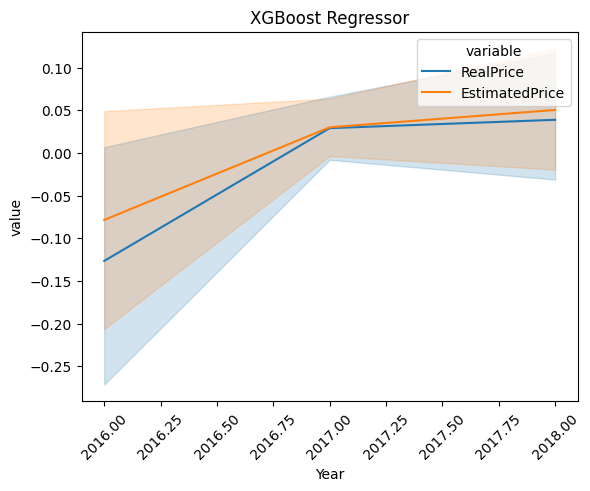

In [17]:
sns.lineplot(x='Year', y='value', hue='variable', data=pd.melt(df_result, id_vars=['Year'], value_vars=['RealPrice', 'EstimatedPrice']))
plt.xticks(rotation=45) 
plt.title("XGBoost Regressor")
plt.savefig("Images/Avocado_Price_Prediction_XGBoost.png")